In [27]:
import os
import sys
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import argrelmax, argrelmin, find_peaks
from sklearn.linear_model import LinearRegression

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
wdir = defs.ROOT / "data" / "interim"

In [145]:
ts = features.load_tide(wdir, "tides-50yr-30s.feather")

slr = 0.005
ts = ts + (ts.index - ts.index[0]) / pd.Timedelta("365.25 days") * slr
ts = ts.loc["2020":"2049"]

In [146]:
sbans = models.TidalFlat(
    tides=ts,
    land_elev_init=2.6,
    conc_bound=0.3,
    grain_diam=3.0e-5,
    grain_dens=2.65e3,
    bulk_dens=900,
    org_rate_yr=2e-4,
    comp_rate_yr=4e-3,
    sub_rate_yr=3e-3,
)
sbans.run()

Progress:   0%|          | 0/10957 [00:00<?, ?day/s]

----------------------------------------
Starting elevation:       2.600       m
Final elevation:          2.924       m
Elevation change:         32.435     cm
----------------------------------------
Aggradation:              52.553     cm
Degradation:              20.404     cm
----------------------------------------
Runtime:                    07 min 21 s


In [147]:
polder = models.TidalFlat(
    tides=ts,
    land_elev_init=1.5,
    conc_bound=0.3,
    grain_diam=3.0e-5,
    grain_dens=2.65e3,
    bulk_dens=900,
    org_rate_yr=2e-4,
    comp_rate_yr=4e-3,
    sub_rate_yr=3e-3,
)
polder.run()

Progress:   0%|          | 0/10957 [00:00<?, ?day/s]

----------------------------------------
Starting elevation:       1.500       m
Final elevation:          2.871       m
Elevation change:         137.136    cm
----------------------------------------
Aggradation:              157.045    cm
Degradation:              20.397     cm
----------------------------------------
Runtime:                    11 min 39 s


In [154]:
polder.settle_rate

0.0008085

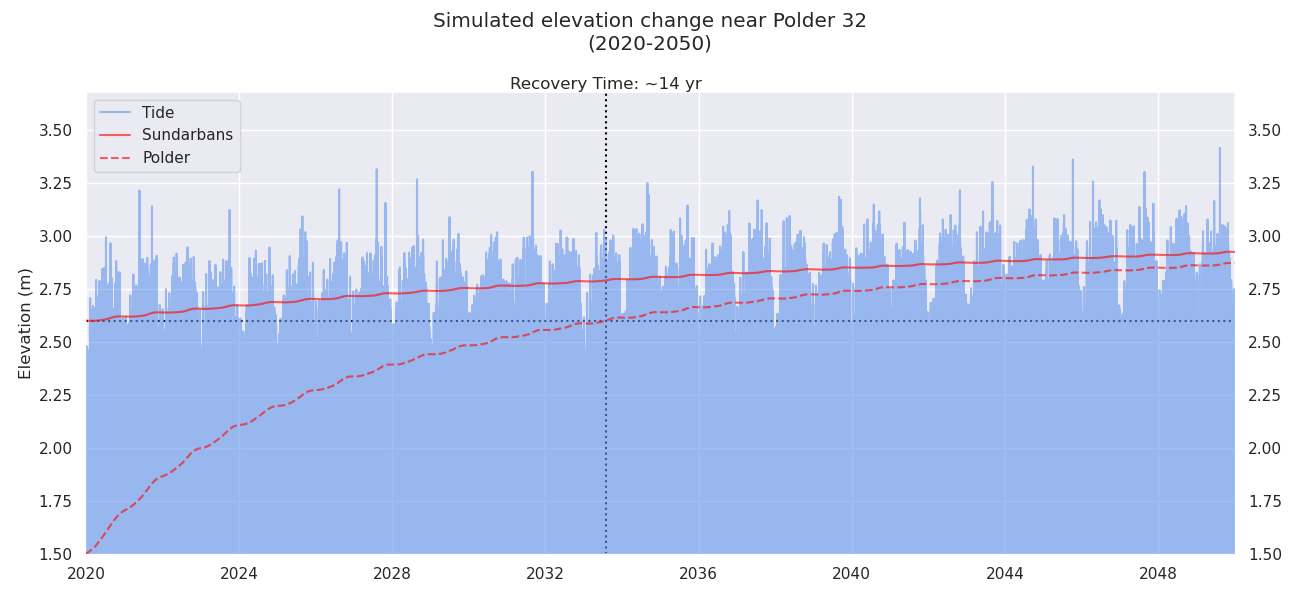

In [153]:
sns.set_theme()
fig = plt.figure(figsize=(13, 6))
ax = fig.subplots()

pdata1 = sbans.results.iloc[::2*60*3]
pdata2 = polder.results.iloc[::2*60*3]

sns.lineplot(data=pdata1, x="datetime", y="tide_elev", ax=ax, color="cornflowerblue", alpha=0.6, label="Tide", zorder=10)
sns.lineplot(data=pdata1, x="datetime", y=pdata1.land_elev, ax=ax, color="red", ls="-", alpha=0.6, label="Sundarbans", zorder=10)
sns.lineplot(data=pdata2, x="datetime", y=pdata2.land_elev, ax=ax, color="red", ls="--", alpha=0.6, label="Polder", zorder=10)

ax.set_xlim(pdata1.datetime.iat[0], pdata1.datetime.iat[-1])
ax.set_ylim(pdata2.land_elev.min())
ax.set_xlabel("")
ax.set_ylabel("Elevation (m)")

loc = polder.results.loc[polder.results.land_elev>sbans.results.land_elev.iat[0]].datetime.iat[0]
years = (loc - sbans.results.datetime.iat[0]) / pd.Timedelta("365.25 days")
s = "Recovery Time: ~{:.0f} yr".format(years)

plt.axhline(y=sbans.results.land_elev.iat[0], ls=":", color="black", zorder=1)
plt.axvline(x=loc, ls=":", color="black", zorder=1)
ax.text(x=loc, y=ax.get_ylim()[1], s=s, rotation=0, ha="center", va="bottom")
ax.tick_params(labelright=True)

fig.suptitle("Simulated elevation change near Polder 32\n(2020-2050)")

plt.tight_layout()